# Create the data based on the following description



In [18]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from scipy.sparse import csr_matrix
import random
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from loss import nll
from box.box_wrapper import BoxTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:

def build_item_attribute_matrix(item_attribute_dict, attribute_list=None):
    items = list(item_attribute_dict.keys())
    attributes = attribute_list if attribute_list else sorted({a for attrs in item_attribute_dict.values() for a in attrs})
    item_idx = {item: i for i, item in enumerate(items)}
    attr_idx = {attr: i for i, attr in enumerate(attributes)}
    matrix = np.zeros((len(items), len(attributes)))
    
    for item, attrs in item_attribute_dict.items():
        for attr in attrs:
            matrix[item_idx[item], attr_idx[attr]] = 1
    return matrix, items, attributes


def jaccard_similarity(matrix):
    A = matrix.astype(bool).astype(int)  # Ensure binary matrix
    n = A.shape[1]
    sim = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                sim[i, j] = 1.0
            else:
                inter = np.logical_and(A[:, i], A[:, j]).sum()
                union = np.logical_or(A[:, i], A[:, j]).sum()
                sim[i, j] = inter / union if union != 0 else 0.0
    return sim


def generate_similarity_based_user_attributes(attr_sim, num_users, top_k=5, diversity_rounds=2):
    num_attributes = attr_sim.shape[0]
    user_attr_matrix = np.zeros((num_users, num_attributes))
    
    for u in range(num_users):
        selected = set()
        for _ in range(diversity_rounds):
            remaining_attrs = [a for a in range(num_attributes) if a not in selected]
            if not remaining_attrs:
                break
            seed = random.choice(remaining_attrs)
            sims = attr_sim[seed]
            probs = sims / sims.sum()
            non_zero_indices = np.where(probs > 0)[0]
            sample_size = min(top_k, len(non_zero_indices))
            chosen = np.random.choice(non_zero_indices, size=sample_size, replace=False)
            selected.update(chosen)
        user_attr_matrix[u, list(selected)] = 1
    return user_attr_matrix

def compute_attribute_overlap(matrix):
    I = matrix
    overlaps = {}
    for a in range(I.shape[1]):
        for b in range(a+1, I.shape[1]):
            Ia, Ib = I[:, a], I[:, b]
            inter = np.logical_and(Ia, Ib).sum()
            if Ia.sum() == 0 or Ib.sum() == 0: continue
            rmax = max(inter / Ia.sum(), inter / Ib.sum())
            rmin = min(inter / Ia.sum(), inter / Ib.sum())
            overlaps[(a, b)] = (rmax, rmin)
    return overlaps

def generate_set_theoretic_rules(overlaps,
                                 num_users,
                                 int_min=2, int_max=10,
                                 not_min=2, not_max=5,
                                 tau1=0.8, tau2=0.2, tau3=0.85):
    user_rules = []
    conjunctions = [pair for pair, (rmax, rmin) in overlaps.items() if rmax < tau1 and rmin > tau2]
    negations = [pair for pair, (rmax, rmin) in overlaps.items() if rmin > tau3]

    for _ in range(num_users):
        num_and_clauses = random.randint(2, 10)
        num_not_clauses = random.randint(2, 5)
        
        P = random.sample(conjunctions, min(num_and_clauses, len(conjunctions)))
        N = random.sample(negations, min(num_not_clauses, len(negations)))
        clause = {"and": P, "not": N}
        user_rules.append(clause)
    return user_rules, conjunctions, negations

def evaluate_dnf_rule(rule, item_attrs):
    # example rule: {'and': [(0, 1), (2, 3)], 'not': [(4, 5)]}
    # need to validate each and and each not rule
    # for this example, we check of 0 and 1, 2 and 3 are present, and 4 is present but 5 is not present.
    for and_clause in rule['and']:
        if all(item_attrs[a] for a in and_clause):
            return 1
    
    for present, not_present in rule['not']:
        if item_attrs[present] and not item_attrs[not_present]:
            return 1

    return 0


def generate_user_item_matrix_dot(Mua, Mia, tau_user=None):
    scores = Mua @ Mia.T
    Mui_dot = np.zeros_like(scores)
    # # theshold over all by 80th percentile
    # threshold = np.percentile(scores, 80)
    # # apply threshold to all scores
    # Mui_dot = (scores > threshold).astype(int)
    # return Mui_dot
    for u in range(scores.shape[0]):
        threshold = tau_user[u] if tau_user is not None else np.percentile(scores[u], 90)
        Mui_dot[u] = (scores[u] > threshold).astype(int)
    return Mui_dot

def generate_user_item_matrix_set(user_rules, Mia):
    num_users = len(user_rules)
    num_items = Mia.shape[0]
    Mui_set = np.zeros((num_users, num_items))
    for u in range(num_users):
        for i in range(num_items):
            Mui_set[u, i] = evaluate_dnf_rule(user_rules[u], Mia[i])
    return Mui_set

def combine_preferences(Mui_dot, Mui_set, p=0.5):
    U = Mui_dot.shape[0]
    z = np.random.binomial(1, p, U)
    return np.array([Mui_set[u] if z[u] else Mui_dot[u] for u in range(U)])

def apply_noise(matrix, noise_fraction=0.1):
    noisy_matrix = matrix.copy()
    indices = np.argwhere(matrix == 1)
    num_flips = int(noise_fraction * len(indices))
    to_flip = indices[np.random.choice(len(indices), num_flips, replace=False)]
    for i, j in to_flip:
        noisy_matrix[i, j] = 0
    return noisy_matrix


Step 1: Load Attribute Item matrix.
Step 2: Get similarity (Jaccard) between attributes
Step 3: 

In [4]:
# Step 1: Example item–attribute dict
# Load item-attribute dict from MovieLens data
item_attr_dict = {}
with open('data/item_tag_dict.txt', 'r') as f:
    for line in f:
        movie_id, tags = line.strip().split(': ')
        item_attr_dict[movie_id] = tags.split(', ')

print(f"Loaded {len(item_attr_dict)} movies with their genres")
print("\nExample items:")
for movie_id, tags in list(item_attr_dict.items())[:5]:
    print(f"Movie {movie_id}: {tags}")

Mia, items, attrs = build_item_attribute_matrix(item_attr_dict)
attr_sim = jaccard_similarity(Mia)

Loaded 3883 movies with their genres

Example items:
Movie 1: ['animation', "children's", 'comedy']
Movie 2: ['adventure', "children's", 'fantasy']
Movie 3: ['comedy', 'romance']
Movie 4: ['comedy', 'drama']
Movie 5: ['comedy']


In [5]:
def plot_spectral_distribution(Mui_dot, Mui_set):
    # Compute singular values
    s_dot = np.linalg.svd(Mui_dot, compute_uv=False)
    s_set = np.linalg.svd(Mui_set, compute_uv=False)
    plt.figure(figsize=(8,5))
    plt.semilogy(s_dot, label='M_dot (dot product)')
    plt.semilogy(s_set, label='M_set (set-theoretic)')
    plt.xlabel('Singular value index')
    plt.ylabel('Singular value (log scale)')
    plt.title('Spectral Distribution of M_dot and M_set')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def calculate_sparsity(matrix):
    return np.sum(matrix == 0) / matrix.size * 100

In [6]:
def get_dataset(Mia, num_users, diversity_rounds, int_min, int_max, not_min, not_max):
    tau1=0.3
    tau2=0.01
    tau3=0.05
    
    Mua = generate_similarity_based_user_attributes(attr_sim, num_users=num_users, diversity_rounds=diversity_rounds)
    overlaps = compute_attribute_overlap(Mia)
    user_rules, conjunctions, negations = generate_set_theoretic_rules(overlaps, num_users=num_users, 
                                                                       int_min=int_min, int_max=int_max,
                                                                       not_min=not_min, not_max=not_max,
                                                                     tau1=tau1, tau2=tau2, tau3=tau3)
    Mui_dot = generate_user_item_matrix_dot(Mua, Mia)
    Mui_set = generate_user_item_matrix_set(user_rules, Mia)
    
    rank_Mui_dot = np.linalg.matrix_rank(Mui_dot)
    print(f"Rank of Mui_dot: {rank_Mui_dot}")
    print(f"Sparsity of Mui_dot: {calculate_sparsity(Mui_dot):.2f}%")
    rank_Mui_set = np.linalg.matrix_rank(Mui_set)
    print(f"Rank of Mui_set: {rank_Mui_set}")
    print(f"Sparsity of Mui_set: {calculate_sparsity(Mui_set):.2f}%")
    plot_spectral_distribution(Mui_dot, Mui_set)

    return Mui_dot, Mui_set, Mua, user_rules, conjunctions, negations

In [5]:
# Step 2: User–attribute preferences
Mua = generate_similarity_based_user_attributes(attr_sim, num_users=NUM_USERS, diversity_rounds=8)


In [11]:
# Step 3: Set-theoretic rules
overlaps = compute_attribute_overlap(Mia)
user_rules, conjunctions, negations = generate_set_theoretic_rules(overlaps, num_users=NUM_USERS, 
                                                                   int_min=1, int_max=3,
                                                                   not_min=0, not_max=1,
                                                                   k=2, l=0, tau1=0.3, tau2=0.01, tau3=0.05)

In [12]:
# print a few user rules in attribute names parse the rules to attribute names

for rule in user_rules[:5]:
    and_clauses = [f"({attrs[a]} & {attrs[b]})" for (a, b) in rule['and']]
    not_clauses = [f"({attrs[present]} & not {attrs[not_present]})" for (present, not_present) in rule['not']]
    all_clauses = and_clauses + not_clauses
    print(" or ".join(all_clauses))

(children's & sci-fi) or (action & thriller) or (horror & thriller) or (comedy & sci-fi) or (sci-fi & western) or (action & not sci-fi) or (mystery & not thriller) or (action & not adventure) or (children's & not sci-fi)
(adventure & musical) or (mystery & sci-fi) or (action & comedy) or (action & thriller) or (adventure & horror) or (adventure & sci-fi) or (crime & romance) or (adventure & animation) or (children's & not fantasy) or (children's & not comedy) or (adventure & not thriller) or (action & not drama) or (crime & not drama)
(musical & romance) or (horror & sci-fi) or (animation & comedy) or (comedy & western) or (comedy & horror) or (adventure & mystery) or (animation & fantasy) or (adventure & romance) or (adventure & musical) or (action & comedy) or (film-noir & not mystery) or (action & not sci-fi) or (mystery & not thriller) or (action & not thriller)
(mystery & romance) or (comedy & crime) or (children's & romance) or (adventure & not sci-fi) or (crime & not drama) or (

In [37]:
# Step 5: Combine preferences
Mui = combine_preferences(Mui_dot, Mui_set, p=0.6)

# Step 6: Inject noise
Mui_noisy = apply_noise(Mui, noise_fraction=0.1)

In [7]:

def train_test_split(matrix, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    train = matrix.copy()
    test = np.zeros_like(matrix)

    for u in range(matrix.shape[0]):
        pos_items = np.where(matrix[u] == 1)[0]
        if len(pos_items) == 0:
            continue
        test_size = max(1, int(test_ratio * len(pos_items)))
        test_items = np.random.choice(pos_items, size=test_size, replace=False)
        train[u, test_items] = 0
        test[u, test_items] = 1

    return train, test

class TrainingDataset(Dataset):
    def __init__(self, user_item_matrix, num_negatives=1):
        self.num_users, self.num_items = user_item_matrix.shape
        self.positives = [(u, i) for u in range(self.num_users) for i in range(self.num_items) if user_item_matrix[u, i] == 1]
        self.negatives = []
        self.num_negatives = num_negatives
        self.user_item_matrix = user_item_matrix

    def __len__(self):
        return len(self.positives)

    def __getitem__(self, idx):
        u, i_pos = self.positives[idx]
        # positive example
        i_neg = np.random.randint(0, self.num_items)
        while self.user_item_matrix[u, i_neg] == 1:
            i_neg = np.random.randint(0, self.num_items)

        # randomly choose to return positive or negative sample
        if np.random.rand() < 0.5:
            return (
                torch.tensor(u, dtype=torch.long),
                torch.tensor(i_pos, dtype=torch.long),
                torch.tensor(1.0, dtype=torch.float)
            )
        else:
            return (
            torch.tensor(u, dtype=torch.long),
            torch.tensor(i_neg, dtype=torch.long),
            torch.tensor(0.0, dtype=torch.float)
            )


    
def evaluate_precision_hit(model, test_matrix, train_matrix, k=10):
    model.eval()
    num_users, num_items = test_matrix.shape
    precision_scores, hit_scores = [], []

    with torch.no_grad():
        for u in range(num_users):
            train_items = set(np.where(train_matrix[u] == 1)[0])
            test_items = set(np.where(test_matrix[u] == 1)[0])
            if not test_items:
                continue

            candidates = [i for i in range(num_items) if i not in train_items]
            user_tensor = torch.tensor([u] * len(candidates)).to(device)
            item_tensor = torch.tensor(candidates).to(device)
            scores = model(user_tensor, item_tensor).cpu().numpy()

            top_k_indices = np.argsort(scores)[-k:][::-1]
            top_k_items = [candidates[i] for i in top_k_indices]

            hits = sum([1 for item in top_k_items if item in test_items])
            precision = hits / k
            hit = 1.0 if hits > 0 else 0.0

            precision_scores.append(precision)
            hit_scores.append(hit)

    avg_precision = np.mean(precision_scores)
    avg_hit = np.mean(hit_scores)
    print(f"Precision@{k}: {avg_precision:.4f}, Hit@{k}: {avg_hit:.4f}")
    return avg_precision, avg_hit


In [8]:
class MFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(MFModel, self).__init__()
        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)
    
    def forward(self, user_idx, item_idx):
        u = self.user_emb(user_idx)
        i = self.item_emb(item_idx)
        dot = (u * i).sum(dim=1)
        return torch.sigmoid(dot)  # since preference is binary

In [19]:
def train(model, dataloader, epochs=5, loss_type='BCE', lr=0.01, name=None, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    if loss_type == 'BCE':
        loss_fn = nn.BCELoss()
    elif loss_type == 'MSE':
        loss_fn = nn.MSELoss()
    elif loss_type == 'NLL':
        loss_fn = nll
    else:
        raise ValueError(f"Invalid loss type: {loss_type}")
    print(f"Training {name} for {epochs} epochs")
    for epoch in range(epochs):
        total_loss = 0.0
        model.train()
        for users, items, labels in dataloader:
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)
            
            preds = model(users, items)
            if loss_type == 'BCE' or loss_type == 'MSE':
                loss = loss_fn(preds, labels)
            elif loss_type == 'NLL':
                # check if labels are 1 or 0
                pred_pos = preds[labels == 1]
                pred_neg = preds[labels == 0]
                loss = nll(pos=pred_pos, neg=pred_neg)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if verbose:
            print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")
            evaluate_precision_hit(model, test_matrix, train_matrix, k=10)


class BoxIntersectionModel(nn.Module):
    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32,
                 intersection_temp=0.01,
                 volume_temp= 0.1):
        
        super().__init__()
        self.user_emb = nn.Embedding(num_users, 2 * embedding_dim)  # z and Z for each user
        self.item_emb = nn.Embedding(num_items, 2 * embedding_dim)  # z and Z for each item
        self.embedding_dim = embedding_dim
        self.intersection_temp = intersection_temp
        self.volume_temp = volume_temp

    def forward(self, user_idx, item_idx):
        # Get user and item box parameters
        user_box_params = self.user_emb(user_idx).view(-1, 2, self.embedding_dim)
        item_box_params = self.item_emb(item_idx).view(-1, 2, self.embedding_dim)
        user_box = BoxTensor(user_box_params)
        item_box = BoxTensor(item_box_params)
        # Compute intersection volume (as a score)
        intersection_vol = user_box.gumbel_intersection_log_volume(item_box, 
                                                                 volume_temp=self.volume_temp,
                                                                 intersection_temp=self.intersection_temp)
        item_vol = item_box.log_soft_volume_adjusted(volume_temp=self.volume_temp,
                                                      intersection_temp=self.intersection_temp)
        conditional_prob = intersection_vol - item_vol
        assert (conditional_prob <= 0).all(), "Log probability can not be positive"
        return conditional_prob


In [20]:
def train_loop(matrix, num_negatives, model, dim, loss_type, epochs, lr, name, verbose=True):
    train_matrix, test_matrix = train_test_split(matrix, test_ratio=0.2)
    train_dataset = TrainingDataset(train_matrix, num_negatives=num_negatives)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    num_users, num_items = train_matrix.shape
    if model == 'MF':
        model = MFModel(num_users, num_items, embedding_dim=64)
    elif model == 'Box':
        model = BoxIntersectionModel(num_users, num_items, embedding_dim=dim)
    model.to(device)
    train(model, train_loader, loss_type=loss_type, epochs=epochs, lr=lr, name=name, verbose=verbose)
    avg_precision, avg_hit = evaluate_precision_hit(model, test_matrix, train_matrix, k=10)
    # for k in [1, 5, 10]:
    #     avg_precision, avg_hit = evaluate_precision_hit(model, test_matrix, train_matrix, k=k)
    return model, avg_precision, avg_hit


## Results

- Num Items 3883
- Num Users 200
- Num attributes 18
#### M_dot
- Mua @ Mia.T > tau (Mua: Generated, Mia: Real data)
- Mia is from real data.
- Mua is created by the common understanding 
    - "If you like this genre you might also like similar genre"
#### User rules

<style>
  .genre { 
    display: inline-block; 
    padding: 2px 6px; 
    margin: 1px; 
    border-radius: 6px; 
    font-size: 90%;
    font-weight: bold;
    color: white;
  }
  .adventure { background-color: #1f77b4; }
  .comedy { background-color: #ff7f0e; }
  .animation { background-color: #2ca02c; }
  .horror { background-color: #d62728; }
  .sci-fi { background-color: #9467bd; }
  .crime { background-color: #8c564b; }
  .thriller { background-color: #e377c2; }
  .war { background-color: #7f7f7f; }
  .action { background-color: #bcbd22; }
  .western { background-color: #17becf; }
  .romance { background-color: #ff9896; }
  .mystery { background-color: #c5b0d5; }
  .fantasy { background-color: #aec7e8; }
  .children { background-color: #98df8a; }
</style>

<p><strong>User 1:</strong><br>
(<span class="genre adventure">Adventure</span> ∧ <span class="genre comedy">Comedy</span>) ∨ 
(<span class="genre animation">Animation</span> ∧ <span class="genre comedy">Comedy</span>) ∨ 
(<span class="genre adventure">Adventure</span> ∧ <span class="genre horror">Horror</span>) ∨ 
(<span class="genre comedy">Comedy</span> ∧ <span class="genre sci-fi">Sci-Fi</span>)
</p>

<p><strong>User 2:</strong><br>
(<span class="genre crime">Crime</span> ∧ <span class="genre horror">Horror</span>) ∨ 
(<span class="genre thriller">Thriller</span> ∧ <span class="genre war">War</span>) ∨ 
(<span class="genre action">Action</span> ∧ <span class="genre western">Western</span>)
</p>

<p><strong>User 3:</strong><br>
(<span class="genre crime">Crime</span> ∧ <span class="genre horror">Horror</span>) ∨ 
(<span class="genre adventure">Adventure</span> ∧ <span class="genre horror">Horror</span>) ∨ 
(<span class="genre adventure">Adventure</span> ∧ <span class="genre comedy">Comedy</span>) ∨ 
(<span class="genre romance">Romance</span> ∧ ¬<span class="genre thriller">Thriller</span>)
</p>

<p><strong>User 4:</strong><br>
(<span class="genre comedy">Comedy</span> ∧ <span class="genre mystery">Mystery</span>) ∨ 
(<span class="genre adventure">Adventure</span> ∧ <span class="genre mystery">Mystery</span>)
</p>

<p><strong>User 5:</strong><br>
(<span class="genre crime">Crime</span> ∧ <span class="genre mystery">Mystery</span>) ∨ 
(<span class="genre comedy">Comedy</span> ∧ <span class="genre fantasy">Fantasy</span>) ∨ 
(<span class="genre children">Children's</span> ∧ <span class="genre sci-fi">Sci-Fi</span>) ∨ 
(<span class="genre action">Action</span> ∧ <span class="genre thriller">Thriller</span>)
</p>



Hypothesis
- M_set is not created by multiplication of matrices, so must be higher M_dot
- For M_set boxes would do better than vectors
- For M_dot vectors would do better than boxes (This we do not know for certain)
    - We do not know which angle we should be hitting for understanding the limitation with boxes.
    - Boxes might not be capturing low rank matrices, even if they do, it will be an overfitting to data.

<table border="1" cellpadding="5" cellspacing="0">
  <thead>
    <tr>
      <th rowspan="2">Matrix type</th>
      <th rowspan="2">Matrix rank</th>
      <th rowspan="2">Matrix sparsity</th>
      <th colspan="2">Vector</th>
      <th colspan="2">Box</th>
    </tr>
    <tr>
      <th>Precision@10</th>
      <th>Hits@10</th>
      <th>Precision@10</th>
      <th>Hits@10</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>M_dot</td>
      <td>130</td>
      <td>90.3</td>
      <td>96.5</td>
      <td>100.0</td>
      <td>91.5</td>
      <td>100.0</td>
    </tr>
    <tr>
      <td>M_set</td>
      <td>188</td>
      <td>93.8</td>
      <td>59.15</td>
      <td>89.0</td>
      <td>72.9</td>
      <td>98.0</td>
    </tr>
    <tr>
      <td>M_combined</td>
      <td>92.4</td>
      <td>194</td>
      <td>--</td>
      <td>--</td>
      <td>--</td>
      <td>--</td>
    </tr>
  </tbody>
</table>





Todo

[ ] M_combined: Right now just a convex sum. Evidently rank increases which is bad? Also need to run these experiments

[ ] Dataset size is small -- 1. Run k-fold cross validation 2. need to scale up.

[ ] Hyperparam search (Some manual tuning is done to make the training work)

[ ] Effect of dimension (current dimension size 64)

[ ] Disjunction = 0

[ ] how to combine -- disjucntion? or convex combination ?

[ ] more on the probing combination.. 

[ ] Size of the dataset might affect generalization... also the dimension of boxes? does it over fit.

[ ] training data size, rank, other meta parameters like the dimensions. 

[ ] Similar for the M_set.

[ ] 


#Plots
- Different size M_set
    - Users: 40, 200, 1000, 3000

- Different dim (for 200 user cases)
    - Vectors: 8, 32, 64, 128, 256
    - Box: 8, 32, 64, 128, 256

- Vary Rank
    - Vectors:  The rank should be 18. But it is high due to thresholding. But the diversification bring the rank down, but how?
    - Boxes: The rank should be

[ ] Todo list


[ ] Check all the functionalities.
- Does the data generation agree with what I have? \\
- What is the rank / sparsity of these metrices?
- Is set is of higher rank?
- Also, study the spectrum of the PCA / SVD to come to the conclusion for ranks.
        Because the matrices might all be high rank because of the noisy or incompelteness. But they might be very close to a low rank, and we are after that approximation. Spectrum analysis would catch that


[ ] What is the best Eval in such scenario?
- Rec evals are more discrete so any poor model might also get hits@10 correct, or might just not get it at all. 
- Maybe RMSE is the way to go. Need to understand more on this.

[ ] check the dot product, does normalization help? Exhaustive search space.

[ ] How to densify the set-aspects.

[ ] Users are defined by latent factors.
 - Should those be boxes?
 - if so then what are the latent factors that are more favourable to boxes


[ ] 
- 

Possibilites
- Test bed for the latent box
- But if the higher dimensions are getting it, then honestly need to understand what is wrong.


Rank of Mui_dot: 15
Sparsity of Mui_dot: 96.96%
Rank of Mui_set: 40
Sparsity of Mui_set: 75.00%


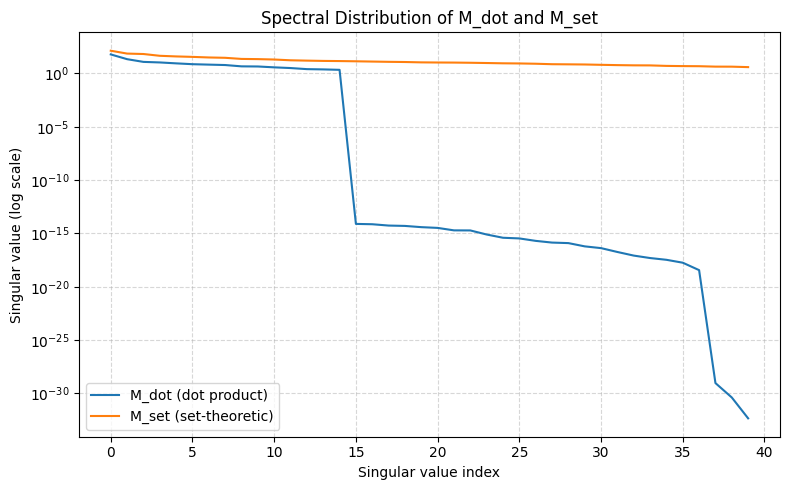

Training Vector for Mui_dot_40 for 60 epochs
Precision@10: 0.5175, Hit@10: 0.9750
Training Box for Mui_dot_40 for 60 epochs
Precision@10: 0.7375, Hit@10: 1.0000
Training Vector for Mui_set_40 for 60 epochs


KeyboardInterrupt: 

In [21]:
Mui_dot_40, Mui_set_40, Mua_40, user_rules_40, conjunctions_40, negations_40 = get_dataset(Mia, num_users=40,
                                                                         diversity_rounds=8,
                                                                         int_min=1, int_max=1, 
                                                                         not_min=0, not_max=0)
model_vector_Mui_dot_40, avg_precision_vector_Mui_dot_40, avg_hit_vector_Mui_dot_40 = train_loop(Mui_dot_40, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_dot_40', verbose=False)
model_box_Mui_dot_40, avg_precision_box_Mui_dot_40, avg_hit_box_Mui_dot_40 = train_loop(Mui_dot_40, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_dot_40', verbose=False)
model_vector_Mui_set_40, avg_precision_vector_Mui_set_40, avg_hit_vector_Mui_set_40 = train_loop(Mui_set_40, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_set_40', verbose=False)
model_box_Mui_set_40, avg_precision_box_Mui_set_40, avg_hit_box_Mui_set_40 = train_loop(Mui_set_40, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_set_40', verbose=False)


Rank of Mui_dot: 54
Sparsity of Mui_dot: 96.24%
Rank of Mui_set: 200
Sparsity of Mui_set: 70.29%


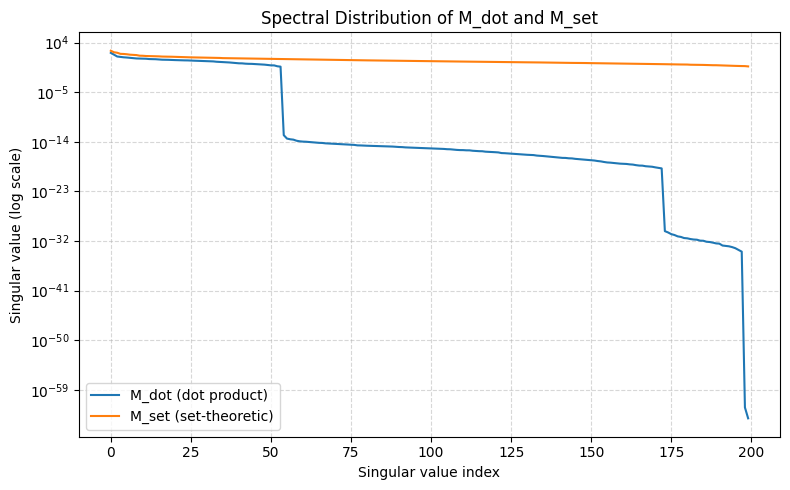

Training Vector for Mui_dot_200 for 60 epochs
Precision@10: 0.7775, Hit@10: 0.9900
Training Box for Mui_dot_200 for 60 epochs
Precision@10: 0.8305, Hit@10: 1.0000
Training Vector for Mui_set_200 for 60 epochs
Precision@10: 0.9055, Hit@10: 1.0000
Training Box for Mui_set_200 for 60 epochs
Precision@10: 0.9475, Hit@10: 1.0000


In [15]:
Mui_dot_200, Mui_set_200, Mua_200, user_rules_200, conjunctions_200, negations_200 = get_dataset(Mia, num_users=200,
                                                                         diversity_rounds=8,
                                                                         int_min=1, int_max=1, 
                                                                         not_min=0, not_max=0)

model_vector_Mui_dot_200, avg_precision_vector_Mui_dot_200, avg_hit_vector_Mui_dot_200 = train_loop(Mui_dot_200, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_dot_200', verbose=False)
model_box_Mui_dot_200, avg_precision_box_Mui_dot_200, avg_hit_box_Mui_dot_200 = train_loop(Mui_dot_200, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_dot_200', verbose=False)

model_vector_Mui_set_200, avg_precision_vector_Mui_set_200, avg_hit_vector_Mui_set_200 = train_loop(Mui_set_200, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_set_200', verbose=False)
model_box_Mui_set_200, avg_precision_box_Mui_set_200, avg_hit_box_Mui_set_200 = train_loop(Mui_set_200, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_set_200', verbose=False)



Rank of Mui_dot: 79
Sparsity of Mui_dot: 96.66%
Rank of Mui_set: 277
Sparsity of Mui_set: 71.40%


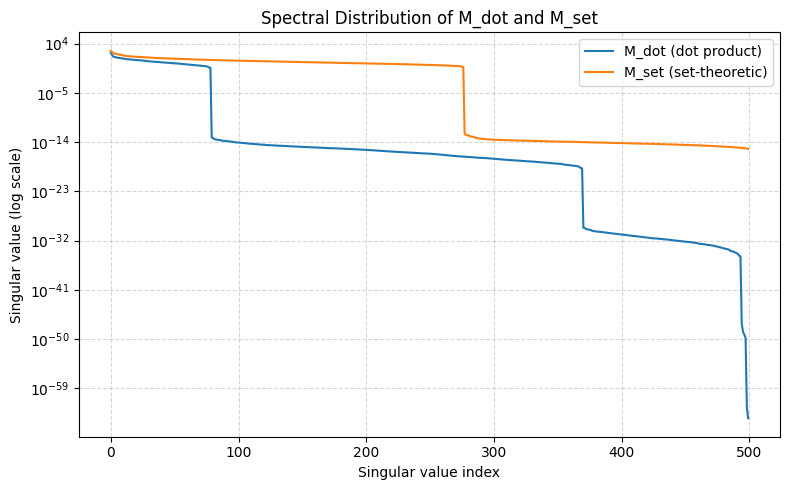

Training Vector for Mui_dot_500 for 60 epochs
Precision@10: 0.8612, Hit@10: 1.0000
Training Box for Mui_dot_500 for 60 epochs
Precision@10: 0.8758, Hit@10: 1.0000
Training Vector for Mui_set_500 for 60 epochs
Precision@10: 0.9878, Hit@10: 1.0000
Training Box for Mui_set_500 for 60 epochs
Precision@10: 0.9360, Hit@10: 1.0000


In [16]:
Mui_dot_500, Mui_set_500, Mua_500, user_rules_500, conjunctions_500, negations_500 = get_dataset(Mia, num_users=500,
                                                                         diversity_rounds=8,
                                                                         int_min=1, int_max=1, 
                                                                         not_min=0, not_max=0)

model_vector_Mui_dot_500, avg_precision_vector_Mui_dot_500, avg_hit_vector_Mui_dot_500 = train_loop(Mui_dot_500, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_dot_500', verbose=False)
model_box_Mui_dot_500, avg_precision_box_Mui_dot_500, avg_hit_box_Mui_dot_500 = train_loop(Mui_dot_500, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_dot_500', verbose=False)

model_vector_Mui_set_500, avg_precision_vector_Mui_set_500, avg_hit_vector_Mui_set_500 = train_loop(Mui_set_500, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_set_500', verbose=False)
model_box_Mui_set_500, avg_precision_box_Mui_set_500, avg_hit_box_Mui_set_500 = train_loop(Mui_set_500, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_set_500', verbose=False)
                                                                         

Rank of Mui_dot: 119
Sparsity of Mui_dot: 96.55%
Rank of Mui_set: 277
Sparsity of Mui_set: 69.72%


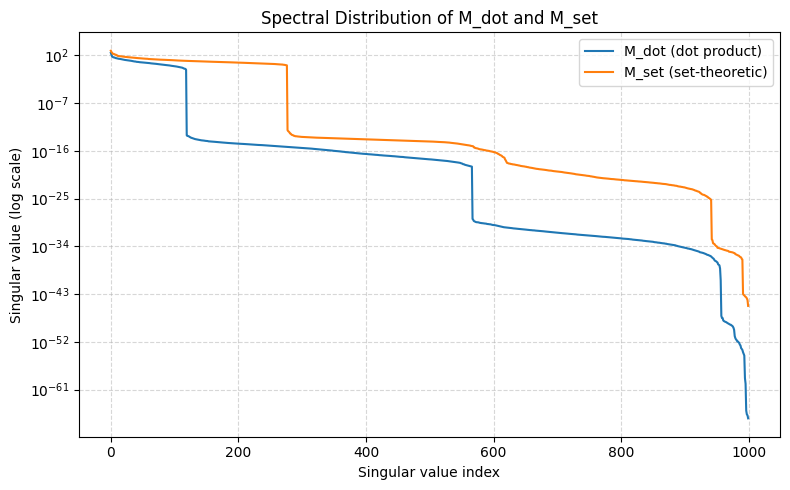

Training Vector for Mui_dot_1000 for 60 epochs
Precision@10: 0.9384, Hit@10: 1.0000
Training Box for Mui_dot_1000 for 60 epochs
Precision@10: 0.9240, Hit@10: 1.0000
Training Vector for Mui_set_1000 for 60 epochs
Precision@10: 0.9960, Hit@10: 1.0000
Training Box for Mui_set_1000 for 60 epochs
Precision@10: 0.9199, Hit@10: 1.0000


In [17]:
Mui_dot_1000, Mui_set_1000, Mua_1000, user_rules_1000, conjunctions_1000, negations_1000 = get_dataset(Mia, num_users=1000,
                                                                         diversity_rounds=8,
                                                                         int_min=1, int_max=1, 
                                                                         not_min=0, not_max=0)

model_vector_Mui_dot_1000, avg_precision_vector_Mui_dot_1000, avg_hit_vector_Mui_dot_1000 = train_loop(Mui_dot_1000, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_dot_1000', verbose=False)
model_box_Mui_dot_1000, avg_precision_box_Mui_dot_1000, avg_hit_box_Mui_dot_1000 = train_loop(Mui_dot_1000, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_dot_1000', verbose=False)

model_vector_Mui_set_1000, avg_precision_vector_Mui_set_1000, avg_hit_vector_Mui_set_1000 = train_loop(Mui_set_1000, 4, 'MF', 64, 'BCE', 60, 0.005, 'Vector for Mui_set_1000', verbose=False)
model_box_Mui_set_1000, avg_precision_box_Mui_set_1000, avg_hit_box_Mui_set_1000 = train_loop(Mui_set_1000, 4, 'Box', 32, 'NLL', 60, 0.005, 'Box for Mui_set_1000', verbose=False)
